# Data prep and EDA

**Objective:** Performing EDA for this project involves preprocessing the data by handling missing values, outliers, and feature engineering. Use statistical and visual techniques  to analyse the relationships between variables, identify patterns for building effective prediction models.

**Actions:**
1. **Create Target Variable:** Define the target variable as the total minutes between created_at and actual_delivery_time.
2. **Handle Missing Values and Outliers:** Address missing values and detect/manage outliers.
3. **Familiarize with the Data:** Explore data distributions and analyze correlations between columns.
4. **Feature Engineering and Dummy Variables:** Create new features and convert categorical variables into dummy variables.

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

### Import Data and Create Target Column

In [22]:
df = pd.read_csv(r"historical_data.csv", parse_dates=["created_at", "actual_delivery_time"]).drop("store_id", axis=1)
df["delivery_duration_min"] = (df["actual_delivery_time"] - df["created_at"]).dt.seconds / 60

df.head(10)

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration_min
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,62.983333
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,67.066667
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,29.683333
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,51.250000
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,39.833333
5,3.0,2015-01-28 20:30:38,2015-01-28 21:08:58,NaN,1.0,3,5000,3,1500,1900,2.0,2.0,2.0,446,338.0,38.333333
6,3.0,2015-01-31 02:16:36,2015-01-31 02:43:00,NaN,1.0,2,3900,2,1200,2700,10.0,9.0,9.0,446,638.0,26.400000
7,3.0,2015-02-12 03:03:35,2015-02-12 03:36:20,NaN,1.0,4,4850,4,750,1800,7.0,8.0,7.0,446,626.0,32.750000
8,2.0,2015-02-16 00:11:35,2015-02-16 00:38:01,indian,3.0,4,4771,3,820,1604,8.0,6.0,18.0,446,289.0,26.433333
9,3.0,2015-02-18 01:15:45,2015-02-18 02:08:57,NaN,1.0,2,2100,2,700,1200,2.0,2.0,2.0,446,715.0,53.200000


### Handle missing values, outliers and filter dataset

In [23]:
# convert cents to dollars
df["subtotal"] = df["subtotal"] / 100
df["min_item_price"] = df["min_item_price"] / 100
df["max_item_price"] = df["max_item_price"] / 100

# convert negative values
columns = ["min_item_price", "max_item_price", "total_onshift_dashers", "total_busy_dashers", "total_outstanding_orders"]
for col in columns: df[col] = df[col].abs()

# missing value and drop nulls
df["store_primary_category"] = df["store_primary_category"].fillna("none")
df.dropna(inplace=True)

# convert numeric columns to categorical
for col in ["market_id", "order_protocol"]:
    df[col] = df[col].astype(int).astype(str)

**It's impossible to have "total_onshift_dashers" less than "total_busy_dashers"**

Based on the description for this dataset:
1. *total_onshift_dashers:* Number of available dashers who are within 10 miles of the store at the time of order creation
2. *total_busy_dashers:* Subset of above total_onshift_dashers who are currently working on an order

In [24]:
# filter data to get rid of outliers (anomaly large values)
df = df.loc[
    (df["total_items"] < 100) & (df["subtotal"] < 25000) &
    (df["min_item_price"] < 100) & (df["max_item_price"].between(1, 100)) &
    (df["estimated_order_place_duration"] < 2000) &
    (df["estimated_store_to_consumer_driving_duration"] < 2000) &
    (df["delivery_duration_min"] > 5) & (df["delivery_duration_min"] < 650),
:]

df = df.query("total_onshift_dashers >= total_busy_dashers")

### Numeric Columns Distribution

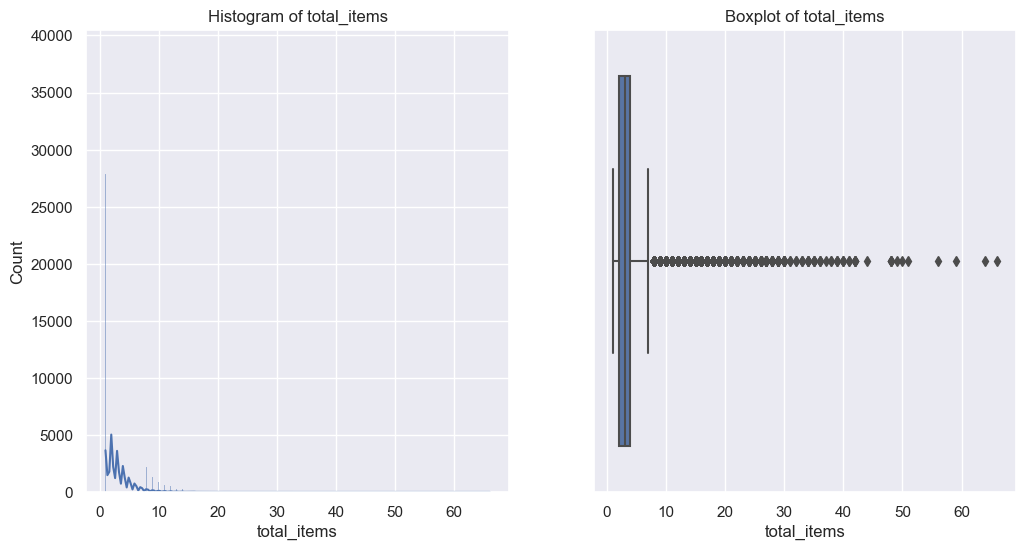

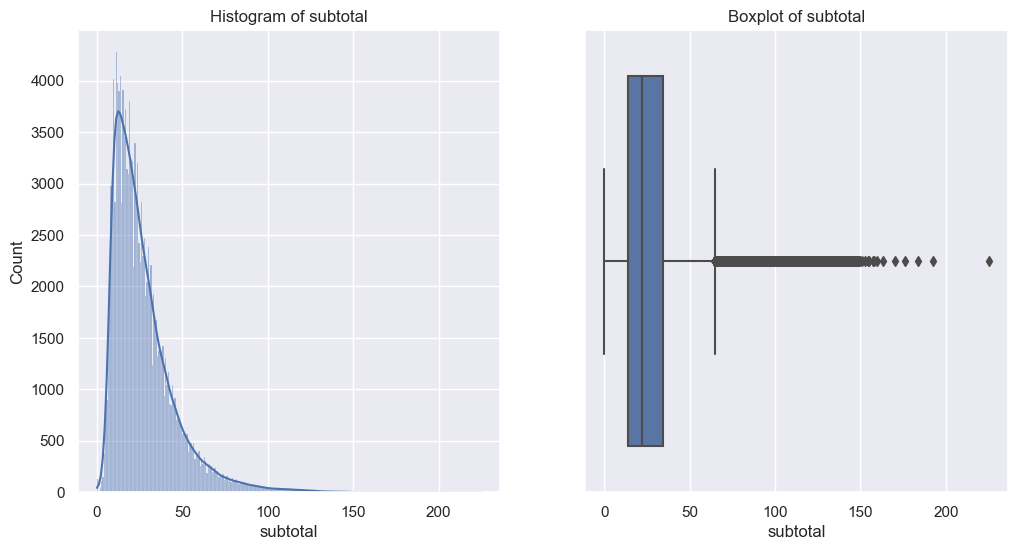

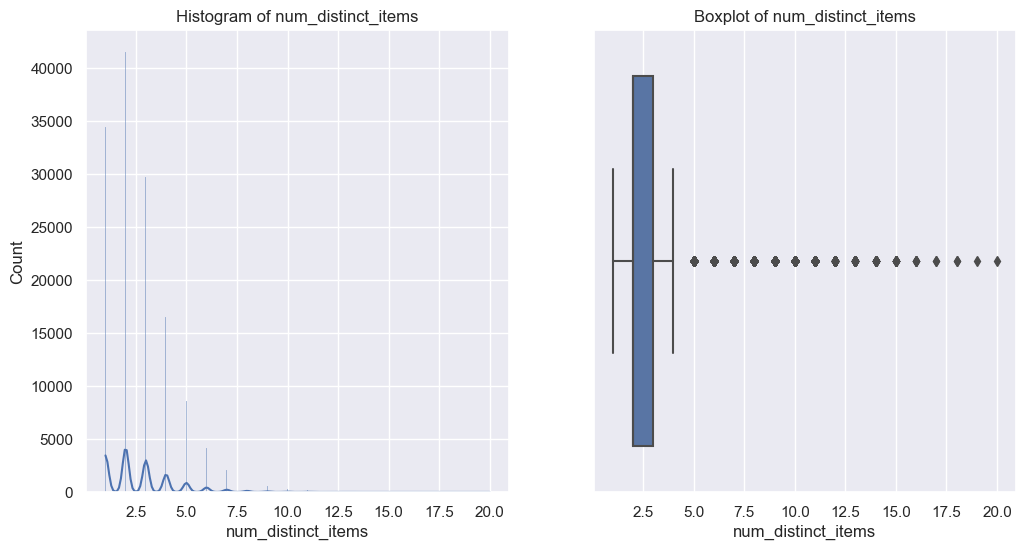

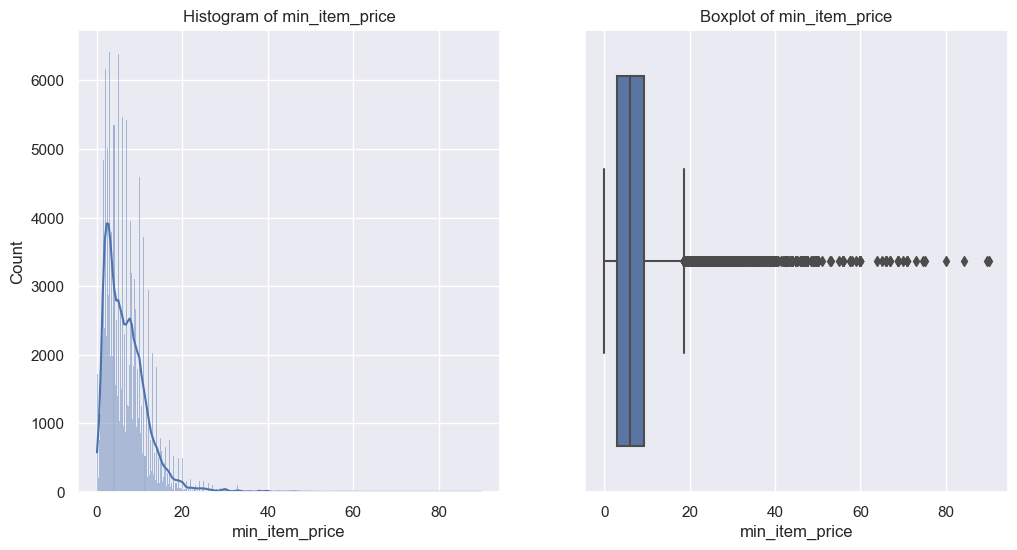

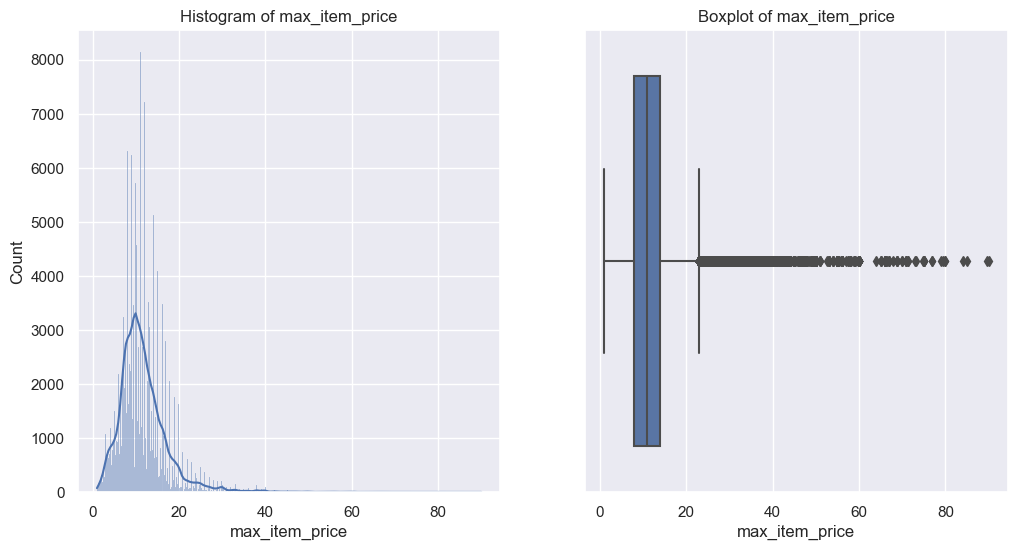

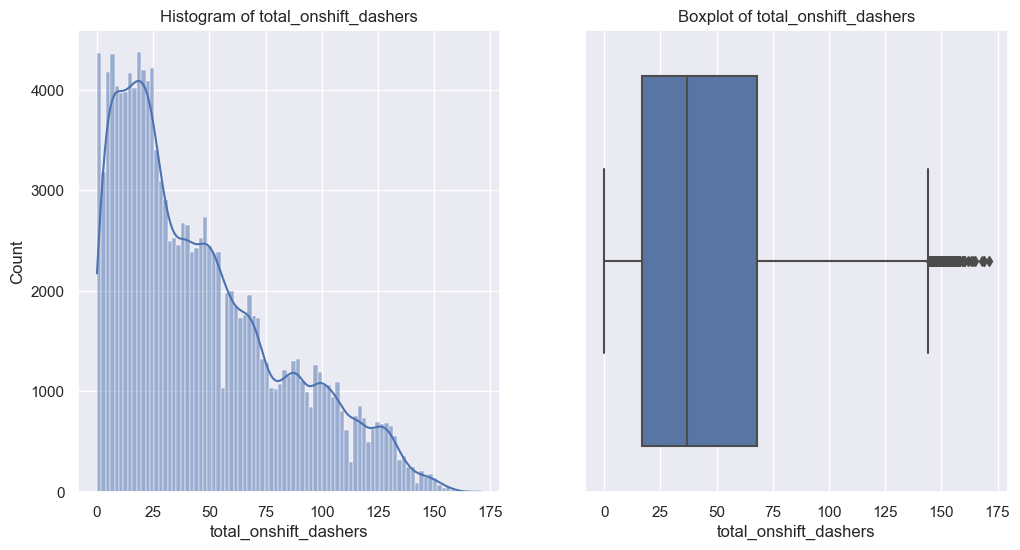

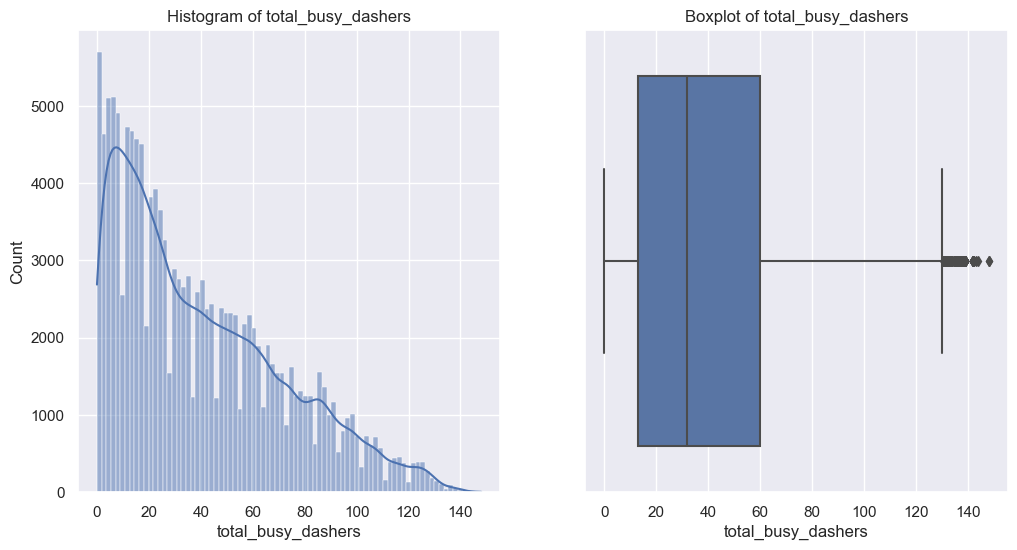

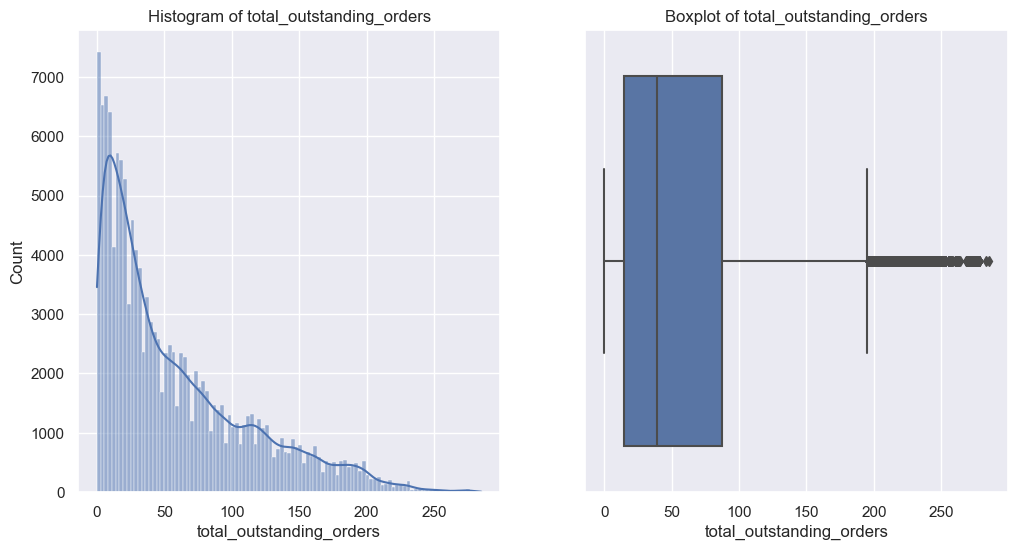

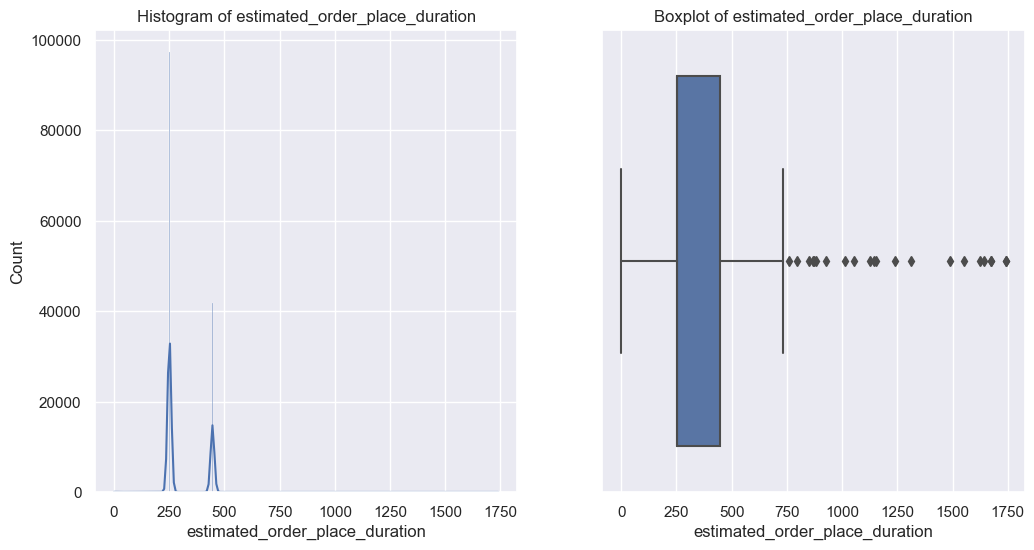

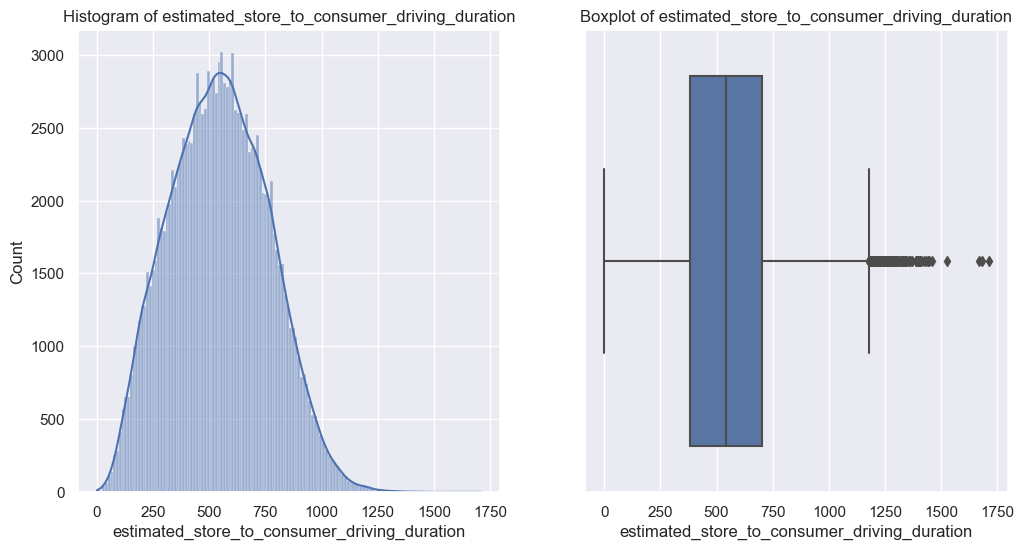

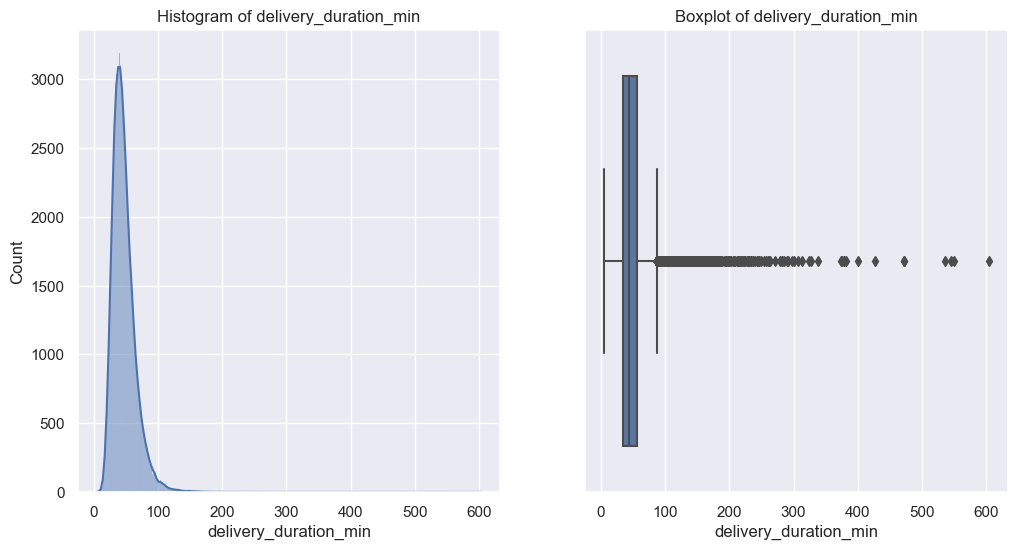

In [25]:
for col in df.select_dtypes("number").columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    sns.histplot(df[col], ax=axes[0], kde=True)
    sns.boxplot(x=df[col], ax=axes[1])
    
    axes[0].set_title(f"Histogram of {col}")
    axes[1].set_title(f"Boxplot of {col}")
    plt.show()

### Categorical Columns Distribution

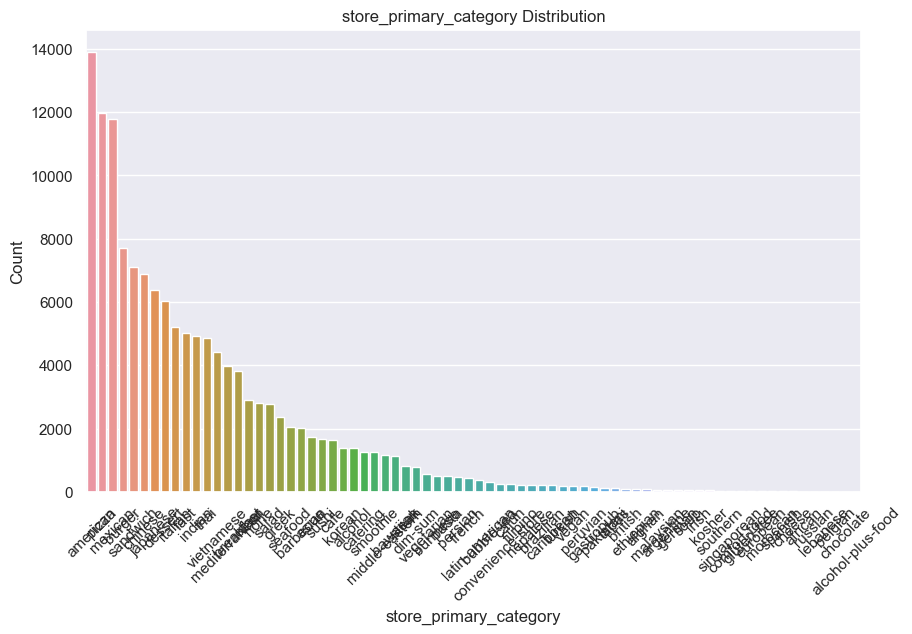

In [26]:
data = df["store_primary_category"].value_counts().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=data, x="store_primary_category", y="count") 
    
plt.title(f"store_primary_category Distribution")
plt.xlabel(f"store_primary_category")
plt.ylabel("Count") 
plt.xticks(rotation=45)
plt.show()

### Feature to Target Correlation Bar Plot

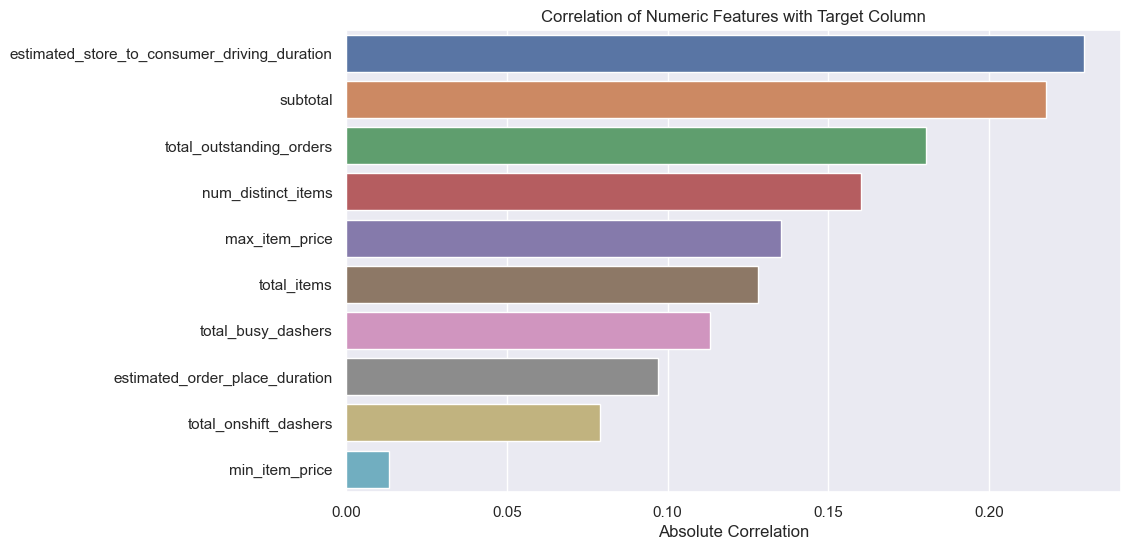

In [27]:
target_correlation = df.corr(numeric_only=True)["delivery_duration_min"].abs().reset_index()[:-1].sort_values("delivery_duration_min", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=target_correlation, x="delivery_duration_min", y="index")
plt.title("Correlation of Numeric Features with Target Column")
plt.xlabel("Absolute Correlation")
plt.ylabel("")
plt.show()

### Feature to Feature Correlation Matrix

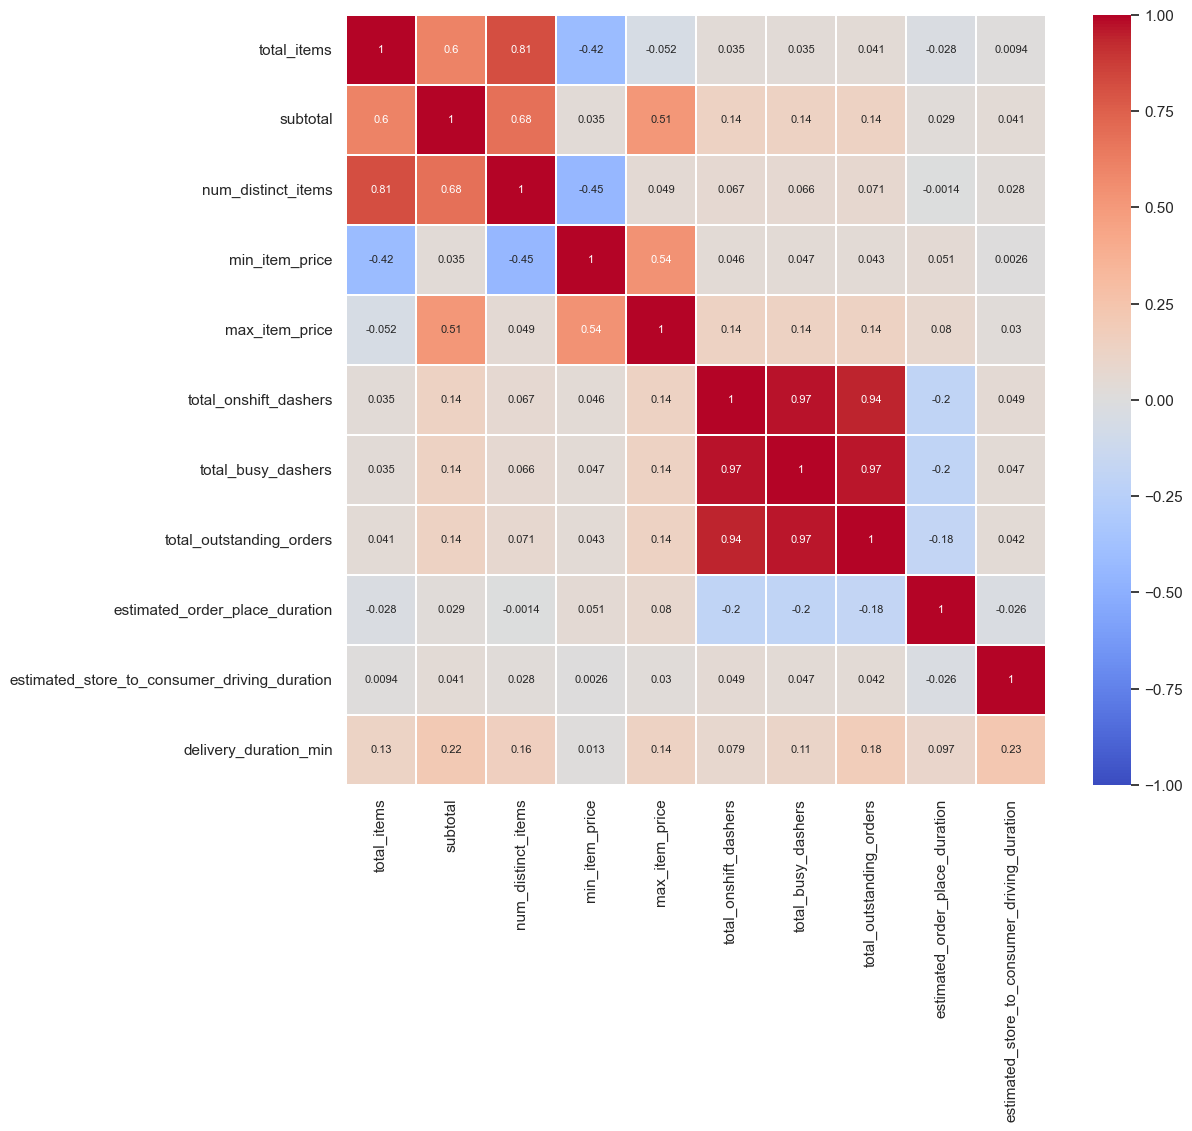

In [28]:
data = df.corr(numeric_only=True).drop("delivery_duration_min", axis=1)

plt.figure(figsize=(12, 10))
sns.heatmap(data, vmin=-1, vmax=1, cmap="coolwarm", annot=True, linewidths=0.1, annot_kws={"size": 8}, square=True)
plt.show()

### Feature Engineering

In [29]:
# date columns
df["month"] = df["created_at"].dt.month_name()
df["day"] = df["created_at"].dt.day_name()
df["is_weekend"] = np.where(df["day"].isin(["Saturday", "Sunday"]), 1, 0)
df["hour"] = df["created_at"].dt.hour

conditions = [
    (df["hour"] >= 5) & (df["hour"] < 12),
    (df["hour"] >= 12) & (df["hour"] < 17),
    (df["hour"] >= 17) & (df["hour"] < 21),
    (df["hour"] >= 21) | (df["hour"] < 5)
]

choices = ["Morning", "Afternoon", "Evening", "Night"]
df["time_of_day"] = np.select(conditions, choices)

In [30]:
df["avg_item_price"] = round(df["subtotal"] / df["total_items"], 2)
df["available_couriers_10_miles"] = df["total_onshift_dashers"] - df["total_busy_dashers"]
df["previous_prediction"] = (df["estimated_order_place_duration"] + df["estimated_store_to_consumer_driving_duration"]) / 60

df.head(10)

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,...,estimated_store_to_consumer_driving_duration,delivery_duration_min,month,day,is_weekend,hour,time_of_day,avg_item_price,available_couriers_10_miles,previous_prediction
0,1,2015-02-06 22:24:17,2015-02-06 23:27:16,american,1,4,34.41,4,5.57,12.39,...,861.0,62.983333,February,Friday,0,22,Night,8.60,19.0,21.783333
2,3,2015-01-22 20:39:28,2015-01-22 21:09:09,none,1,1,19.00,1,19.00,19.00,...,690.0,29.683333,January,Thursday,0,20,Evening,19.00,1.0,18.933333
3,3,2015-02-03 21:21:45,2015-02-03 22:13:00,none,1,6,69.00,5,6.00,18.00,...,289.0,51.250000,February,Tuesday,0,21,Night,11.50,0.0,12.250000
4,3,2015-02-15 02:40:36,2015-02-15 03:20:26,none,1,3,39.00,3,11.00,16.00,...,650.0,39.833333,February,Sunday,1,2,Night,13.00,0.0,18.266667
5,3,2015-01-28 20:30:38,2015-01-28 21:08:58,none,1,3,50.00,3,15.00,19.00,...,338.0,38.333333,January,Wednesday,0,20,Evening,16.67,0.0,13.066667
6,3,2015-01-31 02:16:36,2015-01-31 02:43:00,none,1,2,39.00,2,12.00,27.00,...,638.0,26.400000,January,Saturday,1,2,Night,19.50,1.0,18.066667
8,2,2015-02-16 00:11:35,2015-02-16 00:38:01,indian,3,4,47.71,3,8.20,16.04,...,289.0,26.433333,February,Monday,0,0,Night,11.93,2.0,12.250000
9,3,2015-02-18 01:15:45,2015-02-18 02:08:57,none,1,2,21.00,2,7.00,12.00,...,715.0,53.200000,February,Wednesday,0,1,Night,10.50,0.0,19.350000
10,3,2015-02-02 19:22:53,2015-02-02 20:09:19,none,4,4,43.00,4,12.00,15.00,...,453.0,46.433333,February,Monday,0,19,Evening,10.75,0.0,14.983333
11,3,2015-02-16 04:19:33,2015-02-16 06:34:00,none,1,2,22.00,2,6.00,16.00,...,642.0,134.450000,February,Monday,0,4,Night,11.00,0.0,18.133333


### Dummy Variables

In [31]:
# drop useless columns
columns_to_remove = ["created_at", "actual_delivery_time", "total_onshift_dashers", "total_busy_dashers", "estimated_order_place_duration", "estimated_store_to_consumer_driving_duration"]
filtered_df = df.drop(columns=columns_to_remove)

# create dummy variables
categorical_columns = filtered_df.select_dtypes(include="O").columns
filtered_df = pd.get_dummies(filtered_df, columns=categorical_columns, drop_first=True, dtype=int)

filtered_df.head(10)

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,delivery_duration_min,is_weekend,hour,avg_item_price,...,month_January,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,time_of_day_Evening,time_of_day_Morning,time_of_day_Night
0,4,34.41,4,5.57,12.39,21.0,62.983333,0,22,8.60,...,0,0,0,0,0,0,0,0,0,1
2,1,19.00,1,19.00,19.00,0.0,29.683333,0,20,19.00,...,1,0,0,0,1,0,0,1,0,0
3,6,69.00,5,6.00,18.00,2.0,51.250000,0,21,11.50,...,0,0,0,0,0,1,0,0,0,1
4,3,39.00,3,11.00,16.00,9.0,39.833333,1,2,13.00,...,0,0,0,1,0,0,0,0,0,1
5,3,50.00,3,15.00,19.00,2.0,38.333333,0,20,16.67,...,1,0,0,0,0,0,1,1,0,0
6,2,39.00,2,12.00,27.00,9.0,26.400000,1,2,19.50,...,1,0,1,0,0,0,0,0,0,1
8,4,47.71,3,8.20,16.04,18.0,26.433333,0,0,11.93,...,0,1,0,0,0,0,0,0,0,1
9,2,21.00,2,7.00,12.00,2.0,53.200000,0,1,10.50,...,0,0,0,0,0,0,1,0,0,1
10,4,43.00,4,12.00,15.00,1.0,46.433333,0,19,10.75,...,0,1,0,0,0,0,0,1,0,0
11,2,22.00,2,6.00,16.00,4.0,134.450000,0,4,11.00,...,0,1,0,0,0,0,0,0,0,1


### Export Data for Modeling

In [33]:
filtered_df.to_csv("prep_data.csv", index=False)